# Part 1: Markovian epidemic model

#### Differential equations
$\frac{dS}{dt} = -\beta \frac{I}{N} S$<br/>
$\frac{dI}{dt} = \beta \frac{I}{N} S - \gamma I$<br/>
$\frac{dR}{dt} = \gamma I$, where<br/>
> $\beta$: constant rate of infection i.e. force of infection <br/>
> $\gamma$: constant rate of recovery <br/>
> Initial conditions: S(0) = N - 1, I(0) = 1, R(0) = 0

#### Bayes theorem<br/>
$p(\theta|y) \propto p(y|\theta)p(\theta)$, where
> $\theta$ is the parameter & $y$ is the data

#### Likelihood or sampling distribution
$I_{obs}(t) \sim NegBin(I_{ODE}(t), \phi)$, where
> $I_{obs}(t)$: no. of infected students reported i.e. observed data <br/>
> $I_{ODE}(t)$: no. of infected students solved by ODE <br/>
> $\phi$: dispersion parameter

#### Prior distributions
Since $\theta = (\beta, \gamma, \phi)$, <br/>
Priors: $p(\beta), p(\gamma), p(\phi)$ <br/>

#### Posterior distributions
Joint posterior: $p(\beta, \gamma, \phi|y)$ <br/>
Marginal posteriors: <br/>
$p(\beta|y) = \int \int p(\beta, \gamma, \phi|y) d\gamma, d\phi$ <br/>
$p(\gamma|y) = \int \int p(\beta, \gamma, \phi|y) d\beta d\phi$ <br/>
$p(\phi|y) = \int \int p(\beta, \gamma, \phi|y) d\beta d\gamma$ <br/>

#### Predicted or derived quantities
Posterior distribution of predictions: <br/>
$p(y_{pred}|y) = \int p(y_{pred}|\beta, \gamma, \phi)p(\beta, \gamma, \phi|y) d(\beta, \gamma, \phi)$ <br/>
$p(R_0|y) = \int p(R_0|\beta, \gamma, \phi)p(\beta, \gamma, \phi|y) d(\beta, \gamma, \phi)$

In [1]:
# To install necessary package
install.packages("outbreaks")

Installing package into 'C:/Users/Jiheo/AppData/Local/R/win-library/4.5'
(as 'lib' is unspecified)



package 'outbreaks' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Jiheo\AppData\Local\Temp\RtmpEFEkUK\downloaded_packages


In [2]:
# To load necessary packages
library(outbreaks)
library(cmdstanr)
library(tidybayes)
library(data.table)
library(stringr)
library(ggplot2)

This is cmdstanr version 0.9.0

- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr

- CmdStan path: C:/Users/Jiheo/.cmdstan/cmdstan-2.36.0

- CmdStan version: 2.36.0


A newer version of CmdStan is available. See ?install_cmdstan() to install it.
To disable this check set option or environment variable cmdstanr_no_ver_check=TRUE.



In [3]:
# To load functions
source("sir_func.r")

In [4]:
# To preview epidemic data
print(head(influenza_england_1978_school))

        date in_bed convalescent
1 1978-01-22      3            0
2 1978-01-23      8            0
3 1978-01-24     26            0
4 1978-01-25     76            0
5 1978-01-26    225            9
6 1978-01-27    298           17


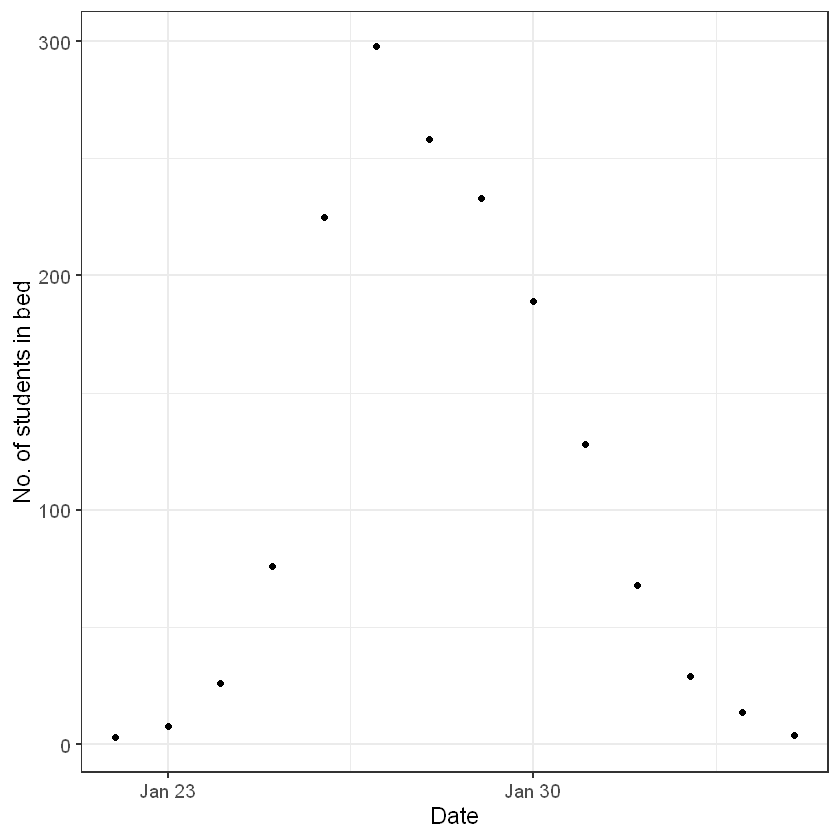

In [5]:
# To plot epidemic data
ggplot(data = influenza_england_1978_school) +
  geom_point(aes(x = date, y = in_bed)) +
  labs(x = "Date", y = "No. of students in bed") +
  theme_bw(base_size = 14)

In [6]:
# To define input data
N <- 763
cases <- influenza_england_1978_school$in_bed
n_days <- length(cases)
t <- seq(from = 0, to = n_days, by = 1)
t0 <- 0
t <- t[-1] # To remove element 1

# To define initial conditions
s0 <- N - 1
i0 <- 1
r0 <- 0
y0 <- c(S = s0, I = i0, R = r0)

# To create a list of input data
sir_data <- list(n_days = n_days, y0 = y0, t0 = t0,
                 ts = t, N = N, cases = cases)

In [7]:
# To compile & fit Stan model
sir_v1_fit <- fit_model("sir_v1", sir_data)

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: neg_binomial_2_lpmf: Location parameter[10] is -8.42623e-08, but must be positive finite! (in 'C:/Users/Jiheo/AppData/Local/Temp/RtmpUxru5K/model-ab45e82500e.stan', line 51, column 4 to column 41)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: neg_binomial_2_lpmf: Location parameter[3] is -9.7961e-08, but must be positive finite! (in 'C:/Users/Jiheo/AppData/Local/Temp/RtmpUxru5K/model-ab45e82500e.stan', line 51, column 4 to column 41)

Chain 1 If this warning occurs sporadically, such as for hig

In [8]:
# To define parameters of interest
parm <- c("beta", "gamma", "phi", "R0", "recovery_time")

# To inspect summary of model fit
sir_v1_summ <- sir_v1_fit$summary(parm)
print(sir_v1_summ)

# A tibble: 5 × 10
  variable       mean median     sd    mad    q5    q95  rhat ess_bulk ess_tail
  <chr>         <dbl>  <dbl>  <dbl>  <dbl> <dbl>  <dbl> <dbl>    <dbl>    <dbl>
1 beta          1.74   1.73  0.0527 0.0475 1.65   1.83   1.00    2657.    2216.
2 gamma         0.542  0.540 0.0474 0.0446 0.472  0.624  1.00    2328.    1875.
3 phi           9.46   8.31  5.27   4.16   3.44  19.2    1.00    2241.    2240.
4 R0            3.22   3.21  0.285  0.263  2.80   3.69   1.00    2509.    2093.
5 recovery_time 1.86   1.85  0.162  0.153  1.60   2.12   1.00    2328.    1875.


In [9]:
# To retrieve posterior samples
sir_v1_post <- data.table(
    gather_draws(sir_v1_fit, beta, gamma, phi)
) |> remove_dots()

# To preview datatable
print(head(sir_v1_post))

   chain iteration  draw variable   value
   <int>     <int> <int>   <char>   <num>
1:     1         1     1     beta 1.73880
2:     1         2     2     beta 1.74547
3:     1         3     3     beta 1.65026
4:     1         4     4     beta 1.70043
5:     1         5     5     beta 1.75430
6:     1         6     6     beta 1.66330


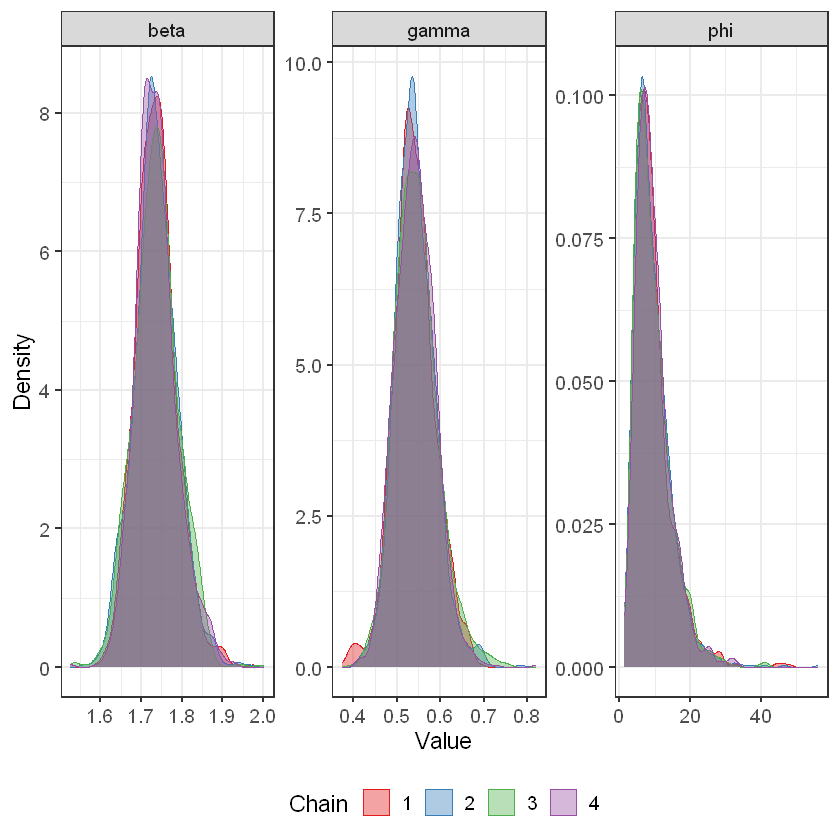

In [10]:
# To plot marginal posterior distributions
plot_post(sir_v1_post)

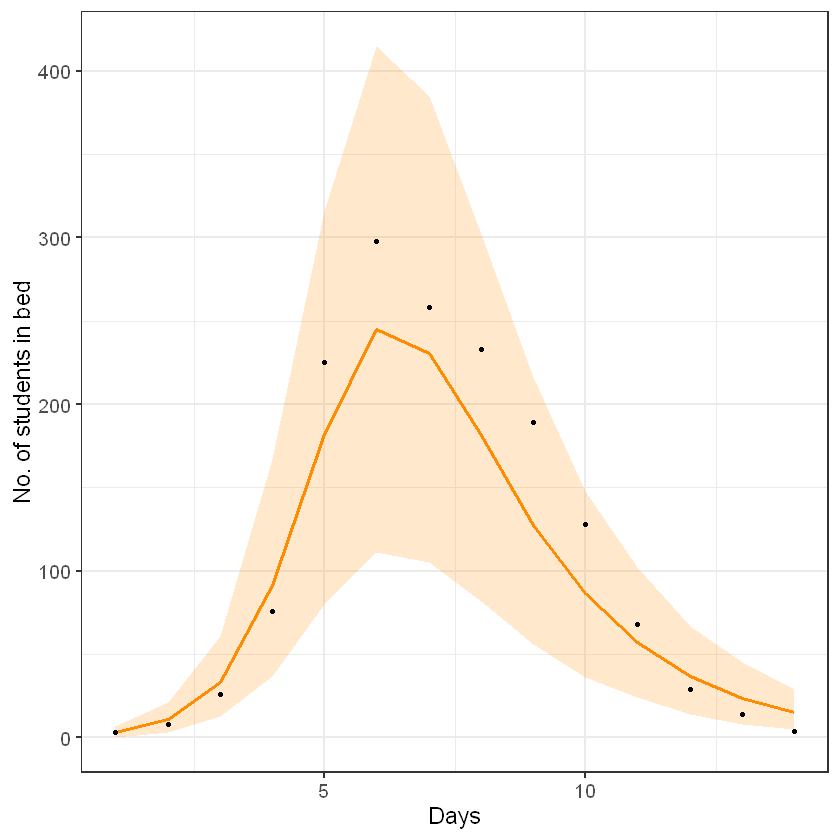

In [11]:
# To check if predicted cases are consistent with observed cases
sir_v1_pred_summ <- data.table(sir_v1_fit$summary(variables = "pred_cases")) |>
  subset(select = c("mean", "q5", "q95")) |> cbind(t, cases)
ggplot(data = sir_v1_pred_summ, mapping = aes(x = t)) +
 geom_ribbon(aes(ymin = q5, ymax = q95), fill = "darkorange", alpha = 0.2) +
 geom_line(mapping = aes(x = t, y = mean), color = "darkorange", linewidth = 1) +
 geom_point(mapping = aes(x = t, y = cases), size = 1) +
 labs(x = "Days", y = "No. of students in bed") +
 theme_bw(base_size = 14)

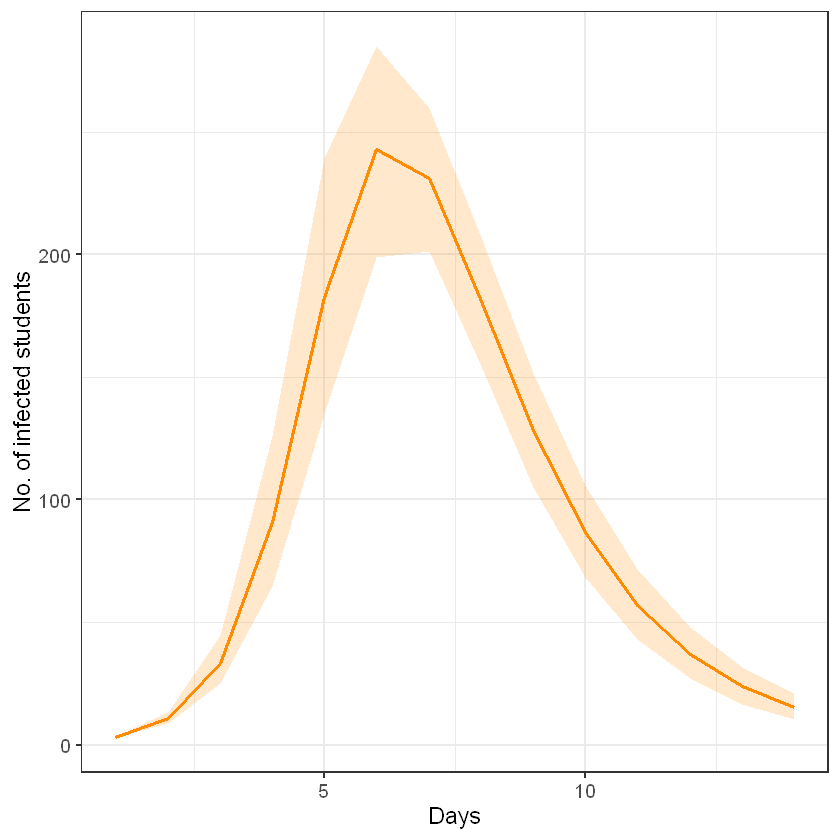

In [12]:
# To obtain deterministic predictions of infected students
inf_parm <- paste0("y[", 1:n_days, ",2]")
sir_v1_inf_summ <- data.table(sir_v1_fit$summary(variables = inf_parm)) |>
  subset(select = c("mean", "q5", "q95")) |> cbind(t)
ggplot(data = sir_v1_inf_summ, mapping = aes(x = t)) +
  geom_ribbon(aes(ymin = q5, ymax = q95), fill = "darkorange", alpha = 0.2) +
  geom_line(mapping = aes(x = t, y = mean), color = "darkorange", linewidth = 1) +
  labs(x = "Days", y = "No. of infected students") +
  theme_bw(base_size = 14)